# Lesson 4 Assignment - Automobile Price Hypothesis Testing
## Author - Rodolfo Lerma

# Abstract

This analysis is divided in the following way:

**1) Preparation work:**

- *First look at the data*
    
- *Data Cleaning*


**2) Analysis:**

- *Definition of function for this analysis:*
    - Normality Test
    - Significance
    - Anova
    
    
- *Normality test for `price` & `log price`*


- *Significance(`price`) by `fuel type`, `aspiration`, `rear Vs front wheel drive`:*
    - a) Fuel Type (gas or diesel)
    - b) Aspiration (std or turbo)
    - c) Drive-wheels (fwd or rwd)


- *ANOVA & Tukey's HSD to test `price` for autos stratified by `body style`:*
    - ANOVA
    - Tukey's HSD


**3) Conclusions**

# 1) Data Preparation

## 1st Look at the data (exploration):

In [1]:
#Load necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as ss
import seaborn as sns
from sklearn.preprocessing import scale
from scipy.stats import kstest
from scipy import stats
import statsmodels.stats.weightstats as ws    
from statistics import mean
import statsmodels.stats.power as ssp

In [2]:
#Cleaned up Dataset location
fileName = "https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/Automobile%20price%20data%20_Raw_.csv"
#fileName = "Automobile_price.csv"

In [3]:
#Import libraries
#Load File
#filename = 'kc_house_data.csv'
auto = pd.read_csv(fileName)
auto.dtypes

symboling              int64
normalized-losses     object
make                  object
fuel-type             object
aspiration            object
num-of-doors          object
body-style            object
drive-wheels          object
engine-location       object
wheel-base           float64
length               float64
width                float64
height               float64
curb-weight            int64
engine-type           object
num-of-cylinders      object
engine-size            int64
fuel-system           object
bore                  object
stroke                object
compression-ratio    float64
horsepower            object
peak-rpm              object
city-mpg               int64
highway-mpg            int64
price                 object
dtype: object

In [4]:
#Check the shape of the data array
auto.shape

(205, 26)

**Summary:**
- The data set contains 205 rows
- The data set has 26 Variables (columns)
- 16 variables are `objects` (to check for missing values), 5 as `int64` and 5 as `float64`

For this analysis we will focus only on the following variables:
- `fuel-type`
- `aspiration`
- `drive-wheels`
- `body-style`
- `price`

## Data Cleaning:

In [5]:
used_columns = ["fuel-type","aspiration","drive-wheels","body-style","price"]
for i in used_columns:
    auto.loc[auto[i] == '?', i] = np.nan
auto[used_columns].isnull().sum()

fuel-type       0
aspiration      0
drive-wheels    0
body-style      0
price           4
dtype: int64

4 missing values from the `price` column will be removed from the analysis

In [6]:
auto.dropna(axis = 0, inplace = True)
auto.shape

(201, 26)

In [7]:
#Column price from str to numeric (int64)
auto['price'] = pd.to_numeric(auto['price'])
auto[used_columns].dtypes

fuel-type       object
aspiration      object
drive-wheels    object
body-style      object
price            int64
dtype: object

In [8]:
#Creating a variable called `price_log`
auto['price_log'] = np.log(auto['price'])
print(auto['price_log'].head())

0    9.510075
1    9.711116
2    9.711116
3    9.543235
4    9.767095
Name: price_log, dtype: float64


# 2) Analysis:

## Definition of functions for this analysis

In this section of the analysis all the functions that will be eventually be called for were placed in a common place so it is easy to find.

### Normality Test

In [9]:
def qq_plot(vec1, vec2):
    plt.figure(figsize=(12, 12)).gca() # define axis
    ax1 = plt.subplot(221) ## setup the left subplot
    ss.probplot(vec1, plot = ax1) ## Plot the left subplot
    ax1 = plt.subplot(222) ## Set up the right subplot
    ss.probplot(vec2, plot = ax1) ## Plot the right subplot

In [10]:
def plot_cums(dist1, dist2):
    ## sort the first data sample:
    data_sorted = np.sort(dist1)
    # calculate the proportional values of samples
    p = 1. * np.arange(len(dist1)) / (len(dist1) - 1)

    # Now plot as line and scatter plot. 
    plt.plot(data_sorted, p, color = 'blue')
    plt.scatter(data_sorted, p, color = 'red')
    
    # sort the seond data sample:
    data_sorted = np.sort(dist2)
    
    # And the second plot
    plt.plot(data_sorted, p, color = 'orange')
    plt.scatter(data_sorted, p, color = 'green')

In [11]:
def ks_test(dat, dist = 'norm'):
    ks_statisic, pvalue = kstest(dat, dist)
    print('KS-statistic = ' + str(ks_statisic))
    print('P-value = ' + str(pvalue))

### Significance

In [12]:
%matplotlib inline
def hist_plot(vec, bins):
    import matplotlib.pyplot as plt
    from statistics import mean
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')
    
def plot_pop(a, b, cols=['pop_A', 'pop_B'], nbins = 20):
    import matplotlib.pyplot as plt
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

In [13]:
def t_test(a, b, alpha, alternative='two-sided'):
    diff = a.mean() - b.mean()

    res = ss.ttest_ind(a, b, equal_var=False)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar='unequal') 
    degfree = means.dof_satt()

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index) 

In [14]:
def hist_mean_ci(vec, t_test, bins):
    upper = mean(vec) + t_test[5] - t_test[1]
    lower = mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

In [15]:
#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
def kde_plot(a,b,c,d,e):
    fig = plt.figure(figsize=(10,8)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(a, ax = ax, label = c)
    sns.kdeplot(b, ax = ax, label = d)
    ax.set_title('KDE plot of auto price ' + e, fontsize = 20) # Give the plot a main title
    ax.set_xlabel('Price', fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper right', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True)

In [16]:
#Box plot function
def box_plot(a,b,c,d,e):
    a = a.tolist()
    b = b.tolist()
    fig = plt.figure(figsize=(10, 6)) # Define plot area
    boxes_sep = 0.4
    ax = sns.boxplot(data=[a, b], palette="Set2", width=boxes_sep)
    ax1 = sns.violinplot(data=[a, b], color=".22", width=boxes_sep)
    plt.setp(ax1.collections, alpha=0.15)
    ax.set_title('Price by ' + e,  fontsize = 20) # Give the plot a main title
    ax.set_ylabel('Price',  fontsize = 15)# Set text for y axis
    plt.xticks([0,1], (c, d))
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)

### ANOVA

In [17]:
def plot_power(x, y, xlabel, title):
    plt.figure(figsize=(8, 6)).gca()
    plt.plot(x, y, color = 'red', linewidth = 2)
    plt.title(title, fontsize = 15)
    plt.xlabel(xlabel, fontsize = 15)
    plt.ylabel('Power', fontsize = 15)
    plt.tick_params(axis="x", labelsize=15)
    plt.tick_params(axis="y", labelsize=15)

In [18]:
def kde_plots(a,b,c,d,e,f,g,h,i,j,k):
    fig = plt.figure(figsize=(10,8)) # Define plot area
    ax = fig.gca() # Define axis 
    sns.set_style("whitegrid")
    sns.kdeplot(a, ax = ax, label = f)
    sns.kdeplot(b, ax = ax, label = g)
    sns.kdeplot(c, ax = ax, label = h)
    sns.kdeplot(d, ax = ax, label = i)
    sns.kdeplot(e, ax = ax, label = j)
    ax.set_title('KDE plot of auto price ' + k, fontsize = 20) # Give the plot a main title
    ax.set_xlabel('Price', fontsize = 15) # Set text for the x axis
    ax.set_ylabel('Density', fontsize = 15)# Set text for y axis
    ax.legend(loc='upper right', fontsize=15)
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)
    ax.grid(True)

In [19]:
#Box plot function
def box_plots(a,b,c,d,e,f,g,h,i,j,k):
    a = a.tolist()
    b = b.tolist()
    fig = plt.figure(figsize=(12, 6)) # Define plot area
    boxes_sep = 0.2
    ax = sns.boxplot(data=[a, b, c, d, e], palette="Set2", width=boxes_sep)
    #ax1 = sns.violinplot(data=[a, b, c, d, e], color=".22", width=boxes_sep)
    #plt.setp(ax1.collections, alpha=0.15)
    ax.set_title('Price by ' + k,  fontsize = 20) # Give the plot a main title
    ax.set_ylabel('Price',  fontsize = 15)# Set text for y axis
    plt.xticks([0,1,2,3,4], (f,g,h,i,j))
    ax.tick_params(axis="x", labelsize=15)
    ax.tick_params(axis="y", labelsize=15)

## Normality test for `price` & `log price`

In this section of the analysis the price distribution along with the price log distribution will be tested for Normality.

In [20]:
#Normalizing each of the price variables so it is possible to see both with same X axis and compare shapes
norm1_s = scale(auto['price'])
norm2_s = scale(auto['price_log'])

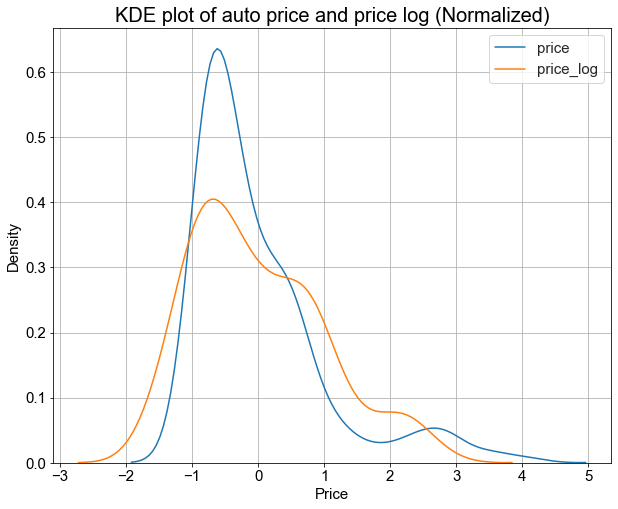

In [21]:
kde_plot(norm1_s,norm2_s,"price","price_log","and price log (Normalized)")

From the figure above it is possible to see that both distributions seem to be close to a normal. But it is also noticiable that the `price_log` variable seems to be closer to a normal distribution.

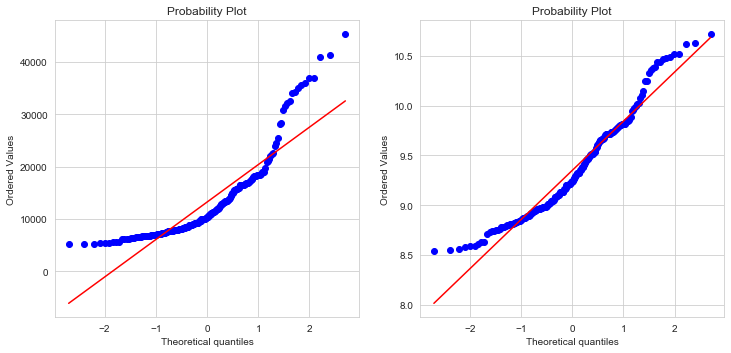

In [22]:
qq_plot(auto['price'], auto['price_log'])  

From the plots above it is possible to see that the closer to Normal distribution line is the second plot, which is the one for the `price_log` distribution. For the `price` distribution it is possible to see that it is quite normal in the center of such distribution and tend to differ at the extremes.

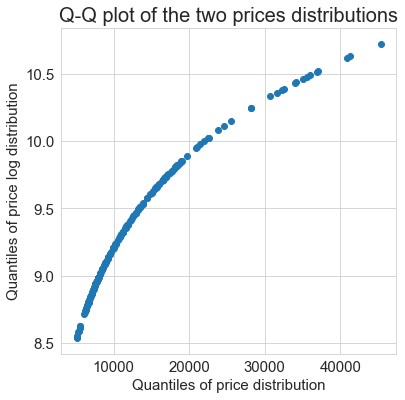

In [23]:
plt.figure(figsize=(6,6)).gca()
plt.scatter(x = sorted(auto['price']), y = sorted(auto['price_log']))
plt.xlabel('Quantiles of price distribution',fontsize = 15)
plt.ylabel('Quantiles of price log distribution',fontsize = 15)
plt.title('Q-Q plot of the two prices distributions',fontsize = 20)
plt.tick_params(axis="x", labelsize=15)
plt.tick_params(axis="y", labelsize=15)

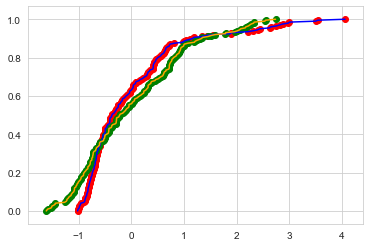

In [24]:
plot_cums(norm1_s, norm2_s)  

As it was seen in before it seems that it is at the extremes where both distributions (`price` & `price_log`) differ. But also it is possible to see some differences at the center.

In [25]:
ks_test(norm1_s)

KS-statistic = 0.1542761480184771
P-value = 0.00012108611006800808


In [26]:
ks_test(norm2_s)

KS-statistic = 0.09781904713791056
P-value = 0.03984598613097214


After carefully looking at both results it is possible to see the following:
- For the `price` distribution the p-value is very small and the K-S statistics relatively large in comparison, therefore we can reject the null hypothesis that the differences between this distribution and a normal distribution are arising from random variation.
- For the `price_log` distribution the p-value is comparable to the K-S statistics,then we cannot reject the null hypothesis that the difference is seen from random variation.

### Conclusions from this section

## Test significance (`price_log`) by `fuel type`, `aspiration`, `rear Vs front wheel drive`

In this part of the analysis it will be explore the possibility that differences in `price` might be seen based on the category of some variables.

In [27]:
#How many unique values we have for each variable
columns = ["fuel-type","aspiration","drive-wheels"]

for i in columns:
    print(auto[i].unique())

['gas' 'diesel']
['std' 'turbo']
['rwd' 'fwd' '4wd']


### a) Fuel Type (gas or diesel)

In [28]:
gas = auto.loc[auto['fuel-type'] == 'gas', 'price_log']
diesel = auto.loc[auto['fuel-type'] == 'diesel', 'price_log']
print('Number of cars running on Gas: ' + str(len(gas)))
print('Number of cars running on Diesel: ' + str(len(diesel)))

Number of cars running on Gas: 181
Number of cars running on Diesel: 20


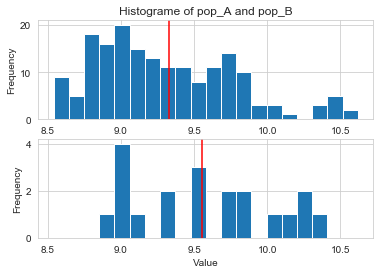

In [29]:
plot_pop(gas, diesel)   

In [30]:
test = t_test(gas, diesel, 0.05)
test

DegFreedom    23.626756
Difference    -0.230212
Statistic     -1.997083
PValue         0.057460
Low95CI       -0.468326
High95CI       0.007901
dtype: float64

In [31]:
Difference = auto.loc[auto['fuel-type'] == 'gas', 'price'].mean() - auto.loc[auto['fuel-type'] == 'diesel', 'price'].mean()
print('The difference in price is: ' + str(abs(int(Difference))) + ' dollars')

The difference in price is: 2921 dollars


It is difficult to see if significant differences in `price_log` (therefore `price`)  can be seen by using the categorical variable `Fuel-Type`. Strictly speaking the p-value is higher than the cutoff value (alpha) of 0.05, therefore it is not possible to reject the null hypothesis. This means that not statistically significant differences are seen by using the `Fuel-Type` category, but the value is so close to the cut-off that it is possible to explore with the customer if the difference it is significant for him/her (expert subject manner).

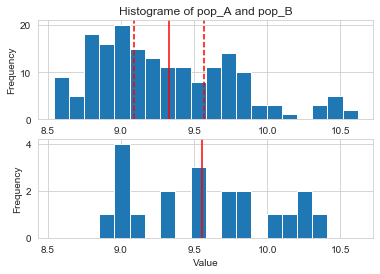

In [32]:
plot_t(gas, diesel, test)  

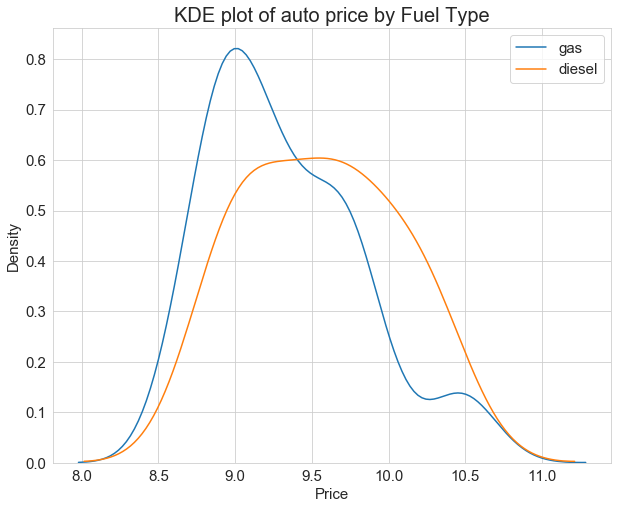

In [33]:
#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
kde_plot(gas,diesel,"gas","diesel","by Fuel Type")

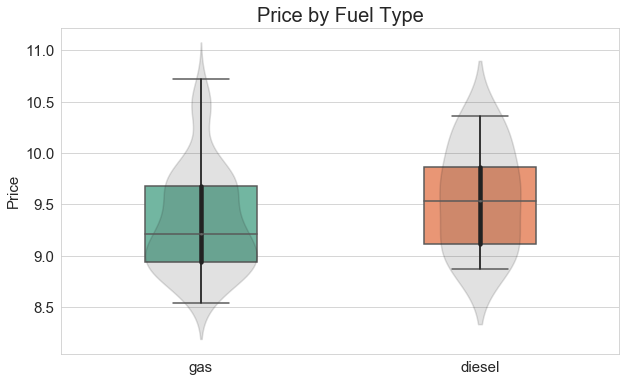

In [34]:
box_plot(gas,diesel,"gas","diesel","Fuel Type")

As it was shown in this section of the analysis, even though there are differences in the `price_log` mean it is possible to see that no super clear differences are noticeable.

### b) Aspiration (std or turbo)

In [35]:
std = auto.loc[auto['aspiration'] == 'std', 'price_log']
turbo = auto.loc[auto['aspiration'] == 'turbo', 'price_log']
print('Number of cars with std aspiration: ' + str(len(std)))
print('Number of cars with turbo aspiration: ' + str(len(turbo)))

Number of cars with std aspiration: 165
Number of cars with turbo aspiration: 36


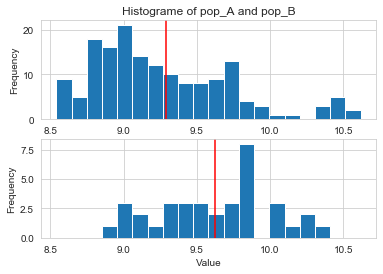

In [36]:
plot_pop(std, turbo)   

In [37]:
test = t_test(std, turbo, 0.05)
test

DegFreedom    64.681296
Difference    -0.335996
Statistic     -4.477688
PValue         0.000031
Low95CI       -0.485870
High95CI      -0.186121
dtype: float64

In [38]:
Difference = auto.loc[auto['aspiration'] == 'std', 'price'].mean() - auto.loc[auto['aspiration'] == 'turbo', 'price'].mean()
print('The difference in price is: ' + str(abs(int(Difference))) + ' dollars')

The difference in price is: 3712 dollars


It is possible to see that there is a statistically significant difference between the `price` of cars with `turbo` compare to `std` aspiration.

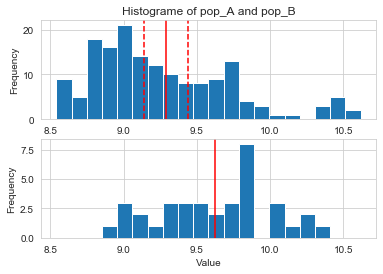

In [39]:
plot_t(std, turbo, test)  

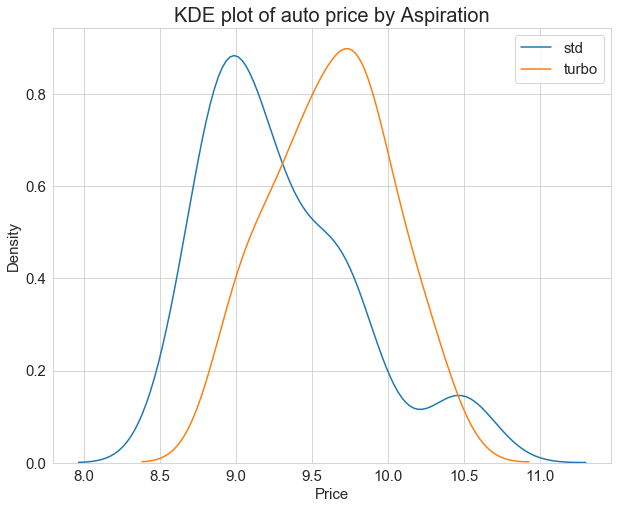

In [40]:
#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
kde_plot(std,turbo,"std","turbo","by Aspiration")

As shown before it is possible to that there is a clear difference in `price` by choosing a `std` or `turbo` car.

### c) Drive-wheels (fwd or rwd)

In [41]:
fwd = auto.loc[auto['drive-wheels'] == 'fwd', 'price_log']
rwd = auto.loc[auto['drive-wheels'] == 'rwd', 'price_log']
print('Number of cars with fwd drive: ' + str(len(fwd)))
print('Number of cars with rwd drive: ' + str(len(rwd)))

Number of cars with fwd drive: 118
Number of cars with rwd drive: 75


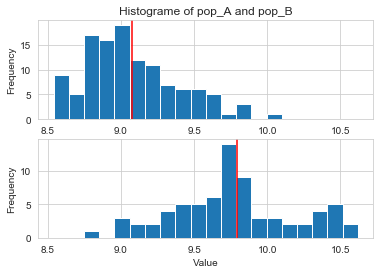

In [42]:
plot_pop(fwd, rwd)   

In [43]:
test = t_test(fwd, rwd, 0.05)
test

DegFreedom    1.235039e+02
Difference   -7.175636e-01
Statistic    -1.227340e+01
PValue        3.964887e-23
Low95CI      -8.332867e-01
High95CI     -6.018405e-01
dtype: float64

In [44]:
Difference = auto.loc[auto['drive-wheels'] == 'fwd', 'price'].mean() - auto.loc[auto['drive-wheels'] == 'rwd', 'price'].mean()
print('The difference in price is: ' + str(abs(int(Difference))) + ' dollars')

The difference in price is: 10512 dollars


It is possible to see that there is a statistically significant difference between the `price` of cars with `turbo` compare to `std` aspiration. As the cutoff value is 0.05 and the P-value is a very small number (close to 0)

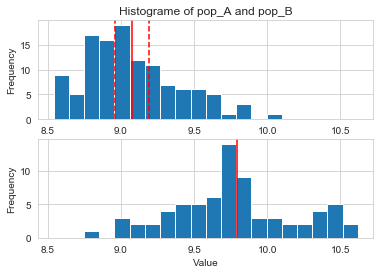

In [45]:
plot_t(fwd, rwd, test)  

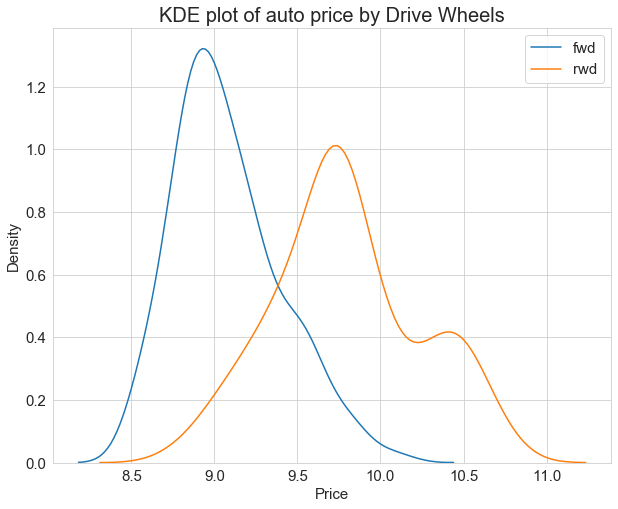

In [46]:
#Kernel Density Estimation Plots (to take a look at the Distribution for each of the variables)
kde_plot(fwd,rwd,"fwd","rwd","by Drive Wheels")

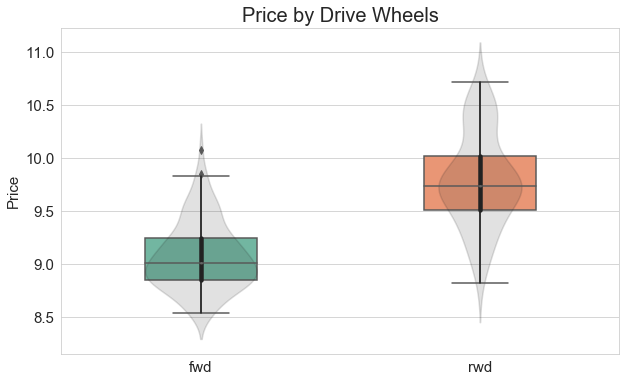

In [47]:
box_plot(fwd,rwd,"fwd","rwd","Drive Wheels")

As shown before it is possible to that there is a clear difference in `price` by choosing a `fwd` or `rwd` car.

### Conclusions of this section:

Is the price significantly different based on the fuel type, aspiration or drive-wheels (rwd & fwd)?

1. For the first case (`Fuel-Type`) it was shown that strictly speaking no differences in `price` can be seen by using this variable and its categories as a predictor of the value of the car, but more analysis has to be done since the value is so close that involving a subject expert matter would be a good option).
2. For the second case (`aspiration`) it is possible to see that there is a clear difference in price by its categories (`std` vs `turbo`), being the `turbo` the most expensive options.
3. For the last case (`wheel-drive`) also was possible to see that there is a clear difference in `price` by choosing a `fwd` or a `rwd` car. Being the former the more expensive option.

##  ANOVA & Tukey's HSD to test `autoprice` to compare `price` for autos stratified by `body style`

In this part of the analysis it will be explore the possibility that differences in `price` might be seen based on characteristic with more than 2 categories. In this case `body-style`, which constains 5 categories.

### ANOVA

In [48]:
#How many unique values we have for each category for the Body Style 
auto['body-style'].value_counts()

sedan          94
hatchback      68
wagon          25
hardtop         8
convertible     6
Name: body-style, dtype: int64

In [49]:
sedan1 = auto.loc[auto['body-style'] == 'sedan', 'price']
hatchback1 = auto.loc[auto['body-style'] == 'hatchback', 'price']
wagon1 = auto.loc[auto['body-style'] == 'wagon', 'price']
hardtop1 = auto.loc[auto['body-style'] == 'hardtop', 'price'] 
convertible1 = auto.loc[auto['body-style'] == 'convertible', 'price']

In [50]:
sedan = auto.loc[auto['body-style'] == 'sedan', 'price_log']
hatchback = auto.loc[auto['body-style'] == 'hatchback', 'price_log']
wagon = auto.loc[auto['body-style'] == 'wagon', 'price_log']
hardtop = auto.loc[auto['body-style'] == 'hardtop', 'price_log'] 
convertible = auto.loc[auto['body-style'] == 'convertible', 'price_log']

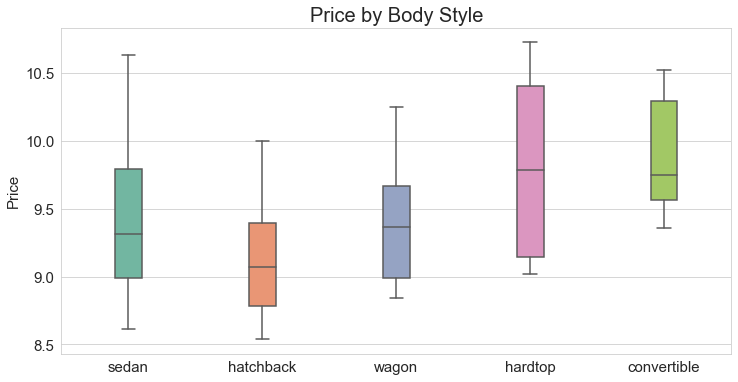

In [51]:
box_plots(sedan,hatchback,wagon,hardtop,convertible,"sedan","hatchback","wagon","hardtop","convertible","Body Style")

By using the `price_log` (which is closer to a Normal distribution) it is possible to see that 2 body styles stand from the rest: `hardtop` and `convertible`. But also those 2 groups are the ones with less data points, so that will be important to balance as to decide on the validity of the results.

C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\ly266e\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


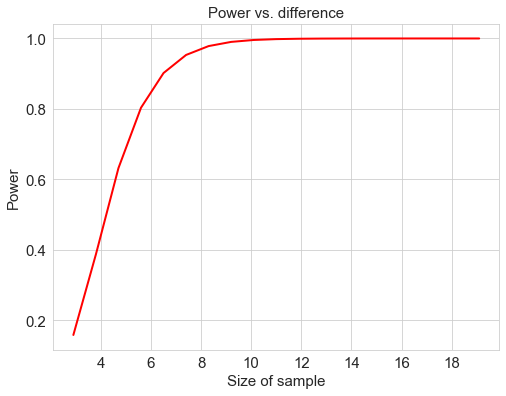

In [52]:
eff_size = (auto['price'].mean())/(auto['price'].std()) #Based on documentation for the FTestAnovaPower().solve_power()
samples = np.arange(2,20,0.9)
#diffs = np.arange(start = 0.1, stop = 1.0, step = 0.01) 
powers = ssp.FTestAnovaPower().solve_power(effect_size = eff_size, nobs=samples, alpha=0.05)
plot_power(samples, powers, xlabel = 'Size of sample', title = 'Power vs. difference') 

From the plot above it is possible to see that for a sample size of 6 (which is the case for `convertible`) the power is around 0.83 and for a sample size 8 (the case for `hardtop`) the power is around 0.95. Above a sample size of 10 the power is 1.0; For this reason I decided to keep the 5 categories for this analysis.

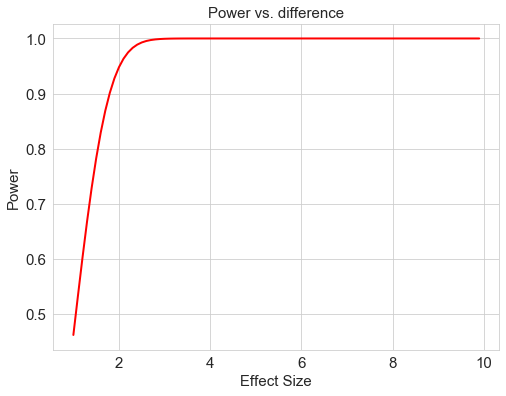

In [53]:
diffs = np.arange(1.0, 10.0, 0.1) # fill in parameters
powers = ssp.FTestAnovaPower().solve_power(effect_size = diffs, nobs=6, alpha=0.05)
plot_power(diffs, powers, xlabel = 'Effect Size', title = 'Power vs. difference')

Even for the worst case scenario which is having a sample of 6 values only, it is possible to see that by having at least a Effect size (mean/std) close to 2 the Power gets to a very considerable level 0.95. There for it is possible to see that since we have a higher sample for all the other variables the power will be higher even for the worst case scenario which is 6 values.

In [54]:
f_statistic, p_value = ss.f_oneway(sedan,hatchback,wagon,hardtop,convertible)
print('F statistic = ' + str(f_statistic))
print('P-value = ' + str(p_value))

F statistic = 8.458887676111926
P-value = 2.573333086083424e-06


We can see that the test is concluding that there is a difference between categories given by the column `wheel-drive`. No more details are given and more exploration will be done in the next section.

### Tukey's HSD

In [55]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
Tukey_HSD = pairwise_tukeyhsd(auto["price"], auto["body-style"])
print(Tukey_HSD)

         Multiple Comparison of Means - Tukey HSD, FWER=0.05          
   group1     group2    meandiff  p-adj     lower      upper    reject
----------------------------------------------------------------------
convertible   hardtop       318.0    0.9 -10641.9651 11277.9651  False
convertible hatchback -11933.0588 0.0018 -20575.8008 -3290.3168   True
convertible     sedan  -7430.7447 0.1214 -15976.0231  1114.5338  False
convertible     wagon    -9518.54 0.0395 -18744.2753  -292.8047   True
    hardtop hatchback -12251.0588  0.001  -19836.365 -4665.7526   True
    hardtop     sedan  -7748.7447  0.038 -15222.8108  -274.6785   True
    hardtop     wagon    -9836.54 0.0105  -18079.966  -1593.114   True
  hatchback     sedan   4502.3141 0.0016   1271.5527  7733.0756   True
  hatchback     wagon   2414.5188 0.6114  -2332.0828  7161.1205  False
      sedan     wagon  -2087.7953 0.6914  -6654.5252  2478.9345  False
----------------------------------------------------------------------


It is possible to see that the analysis shows no difference between `convertible` & `hardtop`, but there are differences (statistically significant ones) between these 2 and the rest of the body styles. 

The only difference between groups outside the `convertible` & `hardtop` categories is for `hatchback` vs `sedan` being the `sedan` more expensive than the `hatchback` (with statistical significance).

In [56]:
auto_updated = auto[(auto["body-style"] != "convertible") & (auto["body-style"] != "hardtop")]

from statsmodels.stats.multicomp import pairwise_tukeyhsd
Tukey_HSD = pairwise_tukeyhsd(auto_updated["price"], auto_updated["body-style"])
print(Tukey_HSD)

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
  group1  group2  meandiff  p-adj    lower      upper   reject
--------------------------------------------------------------
hatchback  sedan  4502.3141  0.001  1939.6669 7064.9614   True
hatchback  wagon  2414.5188 0.2865 -1350.4963 6179.5339  False
    sedan  wagon -2087.7953 0.3641 -5710.1357 1534.5451  False
--------------------------------------------------------------


The difference mentioned above is preserved even when the categories: `convertible` & `hardtop` are removed from the analysis, which is `hatchback` vs `sedan` (statistically significant difference)

In [57]:
#Summary of differences in actual dollars
df = pd.DataFrame({'Body Style': ["convertible","hardtop","hatchback","sedan","wagon"],
                   'mean': auto.groupby('body-style')['price'].mean().astype(int).tolist(),
                   'std': auto.groupby('body-style')['price'].std().astype(int).tolist(),
                   'count': auto.groupby('body-style')['price'].count().astype(int).tolist()}, 
                  columns=['Body Style', 'mean', 'std','count'])
df

,Body Style,mean,std,count
0,convertible,21890,11187,6
1,hardtop,22208,14555,8
2,hatchback,9957,4148,68
3,sedan,14459,8523,94
4,wagon,12371,5120,25


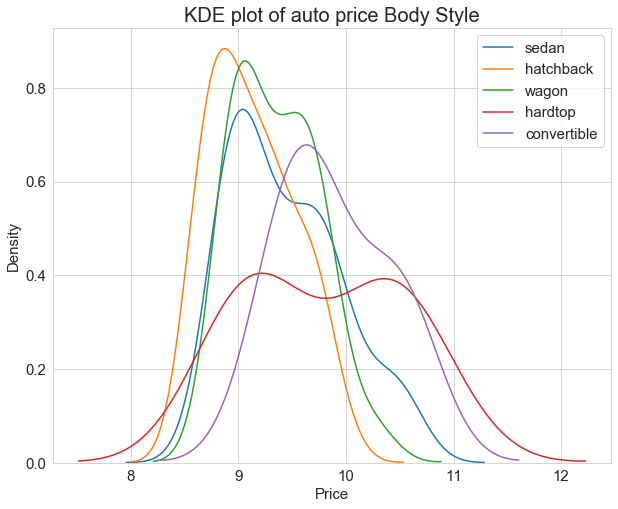

In [58]:
kde_plots(sedan,hatchback,wagon,hardtop,convertible,"sedan","hatchback","wagon","hardtop","convertible","Body Style")

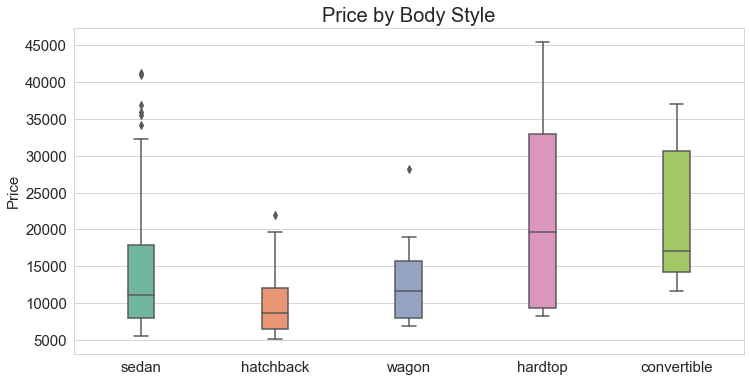

In [59]:
box_plots(sedan1,hatchback1,wagon1,hardtop1,convertible1,"sedan","hatchback","wagon","hardtop","convertible","Body Style")

### Conclusions of this section:

Is the price significantly different based on the body style?

Short answer is yes, but some explanation is probably needed. In this analysis all 5 categories where kept, the main reason for that was the exploration of the **power of test** which showed that even by having a sample of size 6 the power of the test will be around 85%. Based on that and knowing that 6 was the smallest of my sample sizes, I decided to keep all the categories. From this analysis we found:
- There is no difference between `convertible` & `hardtop`, but there are differences (statistically significant ones) between these 2 and the rest of the body styles.

- The only difference between groups outside the `convertible` & `hardtop` categories is for `hatchback` vs `sedan` being the `sedan` more expensive than the `hatchback` (with statistical significance). And this difference is seen even when the `convertible` and `hardtop` categories are removed.

# Summary of conclusions:

### **Normality test for `price` & `log price`:**
After carefully looking at both results it is possible to see the following:
- For the `price` distribution the p-value is very small and the K-S statistics relatively large in comparison, therefore we can reject the null hypothesis that the differences between this distribution and a normal distribution are arising from random variation.
- For the `price_log` distribution the p-value is comparable to the K-S statistics,then we cannot reject the null hypothesis that the difference is seen from random variation.


### **Significance(`price`) by `fuel type`, `aspiration`, `rear Vs front wheel drive`:**

Is the price significantly different based on the fuel type, aspiration or drive-wheels (rwd & fwd)?

- a) Fuel Type (gas or diesel): For the first case (`Fuel-Type`) it was shown that strictly speaking no differences in `price` can be seen by using this variable and its categories as a predictor of the value of the car, but more analysis has to be done since the value is so close that involving a subject expert matter would be a good option).
- b) Aspiration (std or turbo): For the second case (`aspiration`) it is possible to see that there is a clear difference in price by its categories (`std` vs `turbo`), being the `turbo` the most expensive options.
- c) Drive-wheels (fwd or rwd): For the last case (`wheel-drive`) also was possible to see that there is a clear difference in `price` by choosing a `fwd` or a `rwd` car. Being the former the more expensive option.

### **ANOVA & Tukey's HSD to test `price` for autos stratified by `body style`:**

Is the price significantly different based on the body style?

- ANOVA:

    - We can see that the test is concluding that there is a difference between categories given by the column `wheel-drive`. No more details are given and more exploration will be done in the next section.


- Tukey's HSD:

  - Short answer is yes, but some explanation is probably needed. In this analysis all 5 categories where kept, the main reason for that was the exploration of the **power of test** which showed that even by having a sample of size 6 the power of the test will be around 85%. Based on that and knowing that 6 was the smallest of my sample sizes, I decided to keep all the categories. From this analysis we found:
  
    - There is no difference between `convertible` & `hardtop`, but there are differences (statistically significant ones) between these 2 and the rest of the body styles.

    - The only difference between groups outside the `convertible` & `hardtop` categories is for `hatchback` vs `sedan` being the `sedan` more expensive than the `hatchback` (with statistical significance). And this difference is seen even when the `convertible` and `hardtop` categories are removed.